# **Super-Classifier**
## Introduction
For the final project of AI-2, our team Zenith - **Vishnu, Yashraj, Meghana** and **Gunakar** worked together on creating a Super-Classifier to exhibit the improvement in the accuracy of a classifier model when high-resolution images are fed as input.
We applied our skills gained during the course and explored new possibilites that can lead to better results.


## Project Motivation

Generally, a cause of unsatisfactory results from a Classification model is due to the low-quality images that are taken from the internet or a low-resolution camera.

To overcome this issue we can first upscale the image resolution before feeding it into the Classifier, which we have implemented using Transfer Learning.





## Aim

- Use Autoencoder to enhance resolution of images.

- Analyze SOTAs and use them to classify dog breeds.

- Examine if the classifier accuracy is enhanced when resolution-upscaled images are used for training the model.
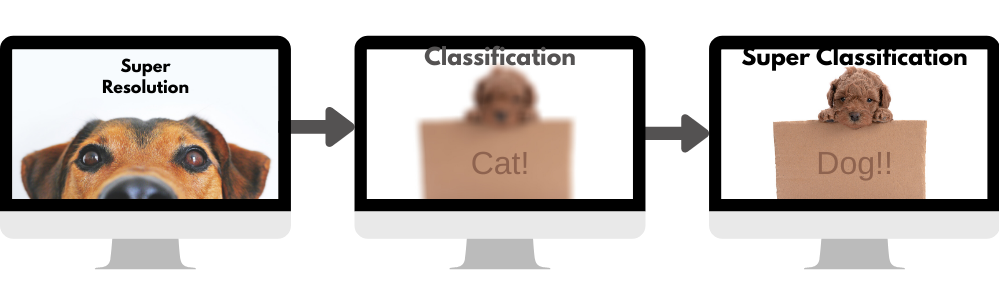
<hr style="height:2pt">

In [2]:
!pip3 -qq install tf_keras_vis 

# Importing necessary packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow .keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, UpSampling2D, add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1, l2
import IPython
import cv2
import os

IPython.display.clear_output() 

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

import tensorflow_addons as tfa

## Dataset
We have used the [Stanford Dogs Dataset]("https://www.kaggle.com/jessicali9530/stanford-dogs-dataset"). It contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.

In [4]:
! pip install -q kaggle

# Uploading kaggle.json for the kaggleAPI
from google.colab import files 
files.upload()

# Downloading the Dataset 
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jessicali9530/stanford-dogs-dataset
! unzip /content/stanford-dogs-dataset.zip
IPython.display.clear_output() 

Found 20580 images belonging to 120 classes.


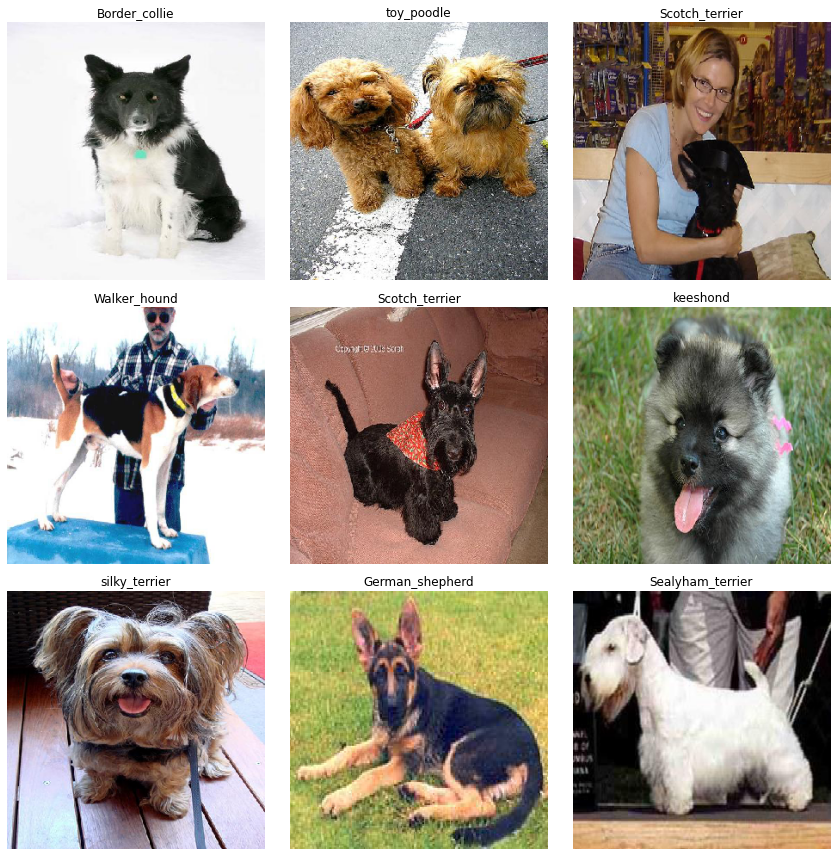

In [5]:
# Making the image data generator for train and test sets
data_dir = "/kaggle/input/stanford-dogs-dataset/images/Images"
image_size = (300,300)
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255).flow_from_directory(data_dir, 
                                        target_size=image_size,
                                        color_mode="rgb",
                                        class_mode="categorical",
                                        batch_size=1,
                                        shuffle=True)

classes = {num:i.split('-')[-1] for i, num in img_gen.class_indices.items()}

fig, axes = plt.subplots(3,3,figsize=(12,12))
axes = axes.ravel()
for ax in axes:
    img = img_gen.next()
    ax.imshow(img[0][0])
    ax.set_title(classes[img[1][0].argmax()])
    ax.axis('off')
fig.tight_layout()

## **Part A**: Super-Resolution

In [6]:
def preprocess_img(img, factor=2):
  img = np.array(img)
  img_n = cv2.resize(img, (img.shape[0]//factor, img.shape[1]//factor))       #shrink img
  img_n = cv2.resize(img_n, (img_n.shape[0]*factor, img_n.shape[1]*factor))   #expand img 
  return img_n

def preprocess_batch(X, factor=2):
    res = []
    for img in X:
        res.append(preprocess_img(img, factor))
    return np.array(res)

Found 18571 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.



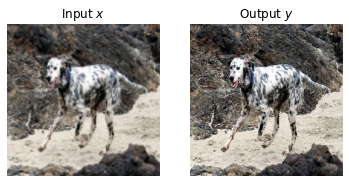

In [7]:
# Making the image data generator for train and test sets
image_size = (300,300)
BATCH_SIZE = 32
compression_factor=2

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.1)


train_gen = datagen.flow_from_directory(data_dir, 
                                        target_size=image_size,
                                        color_mode="rgb",
                                        class_mode="input",
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        subset='training')

val_gen = datagen.flow_from_directory(data_dir, 
                                        target_size=image_size,
                                        color_mode="rgb",
                                        class_mode="input",
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        subset='validation')

train_gen_new = map(lambda X: (preprocess_batch(X[0], compression_factor), X[1]), train_gen)
val_gen_new = map(lambda X: (preprocess_batch(X[0], compression_factor), X[1]), val_gen)

_, axes = plt.subplots(1,2)
img = next(train_gen_new)
axes[0].imshow(img[0][0])
axes[0].set_title("Input $x$")
axes[0].axis('off')

axes[1].imshow(img[1][0])
axes[1].set_title("Output $y$")
axes[1].axis('off')
print()

### Autoencoder Architecture

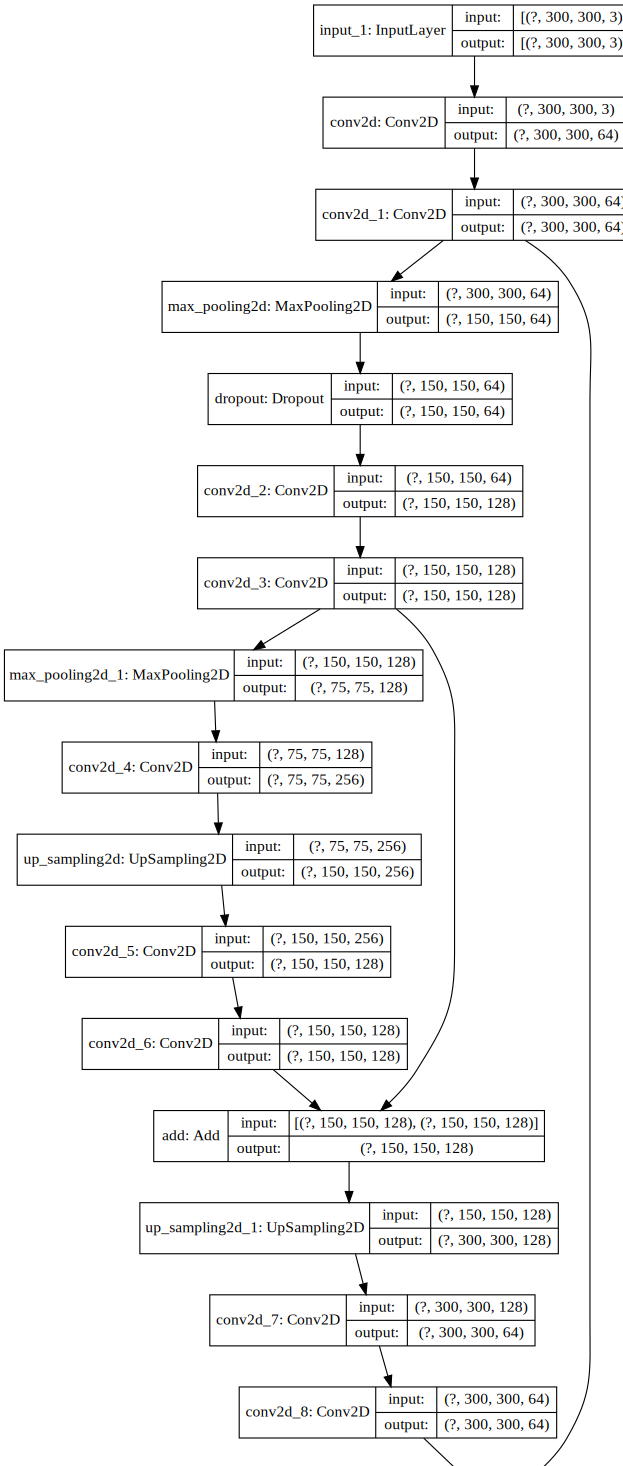

In [8]:
###Model architecture -> https://medium.com/analytics-vidhya/super-resolution-using-autoencoders-and-tf2-0-505215c1674

###Building autoencoder using functional api
reg = 1e-9

#Encoder
input_img = Input(shape=(300,300,3))

l1 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(reg))(input_img)

l2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(reg))(l1)

l3 = MaxPooling2D(padding = 'same')(l2)
l3 = Dropout(0.3)(l3)

l4 = Conv2D(128, (3, 3),  padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(reg))(l3)

l5 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(reg))(l4)

l6 = MaxPooling2D(padding = 'same')(l5)

l7 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(reg))(l6)

#Decoder
l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
            activity_regularizer = regularizers.l1(reg))(l8)

l10 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(reg))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)

l13 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(reg))(l12)

l14 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(reg))(l13)

l15 = add([l14, l2])

decoded = Conv2D(3, (3, 3), padding = 'same', activation = 'sigmoid',
                 activity_regularizer = regularizers.l1(reg))(l15)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3),
                    loss = 'mse')


#Model summary
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model


plot_model(autoencoder, to_file='auto_encoder.png')
SVG(model_to_dot(autoencoder, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

### Training the model

Epoch 1/6
580/580 [==============================] - 533s 919ms/step - loss: 0.0080 - val_loss: 0.0034
Epoch 2/6
580/580 [==============================] - 526s 908ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 3/6
580/580 [==============================] - 527s 908ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 4/6
580/580 [==============================] - 526s 907ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/6
580/580 [==============================] - 526s 906ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/6
580/580 [==============================] - 525s 905ms/step - loss: 0.0029 - val_loss: 0.0027
CPU times: user 46min 6s, sys: 7min 39s, total: 53min 45s
Wall time: 52min 53s


Text(0.5, 1.0, 'Loss Plot')

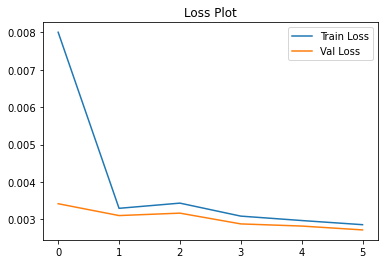

In [9]:
%%time
BATCH_SIZE=32
history = autoencoder.fit(train_gen_new, epochs=6,
        verbose=1, validation_data=val_gen_new, 
        steps_per_epoch=train_gen.n//BATCH_SIZE,
        validation_steps=val_gen.n//BATCH_SIZE)

plt.plot(history.history["loss"], label='Train Loss')
plt.plot(history.history["val_loss"], label='Val Loss')
plt.legend()
plt.title("Loss Plot")

### Validating the model


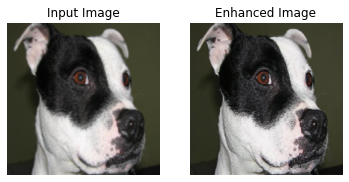

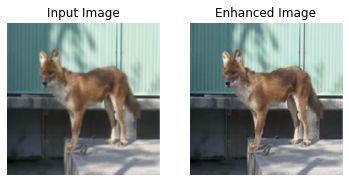

In [15]:
# Visualizing the output of the model
def plot_network(model):
        img = val_gen.next()
        _, ax = plt.subplots(1,2)

        noisy_img = preprocess_img(img[0][0], compression_factor)

        ax[0].imshow(noisy_img)
        ax[0].set_title("Input Image")
        ax[0].axis('off')

        ax[1].imshow(model.predict(np.expand_dims(noisy_img, axis=0))[0])
        ax[1].set_title("Enhanced Image")
        ax[1].axis('off')

num_pics = 2
for _ in range(num_pics):
    plot_network(autoencoder)

We see model output images looks clearer than input noisy images. Hence autoencoder successfully enhances resolution of the image.

In [11]:
# Saving the model
autoencoder.save("SuperResolution")
!zip "SuperResolution.zip" -r ./SuperResolution
IPython.display.clear_output() 

## **Part B**: Classification

### Reading the data

In [34]:
# Creating image data generator for train and test sets
data_dir = "/kaggle/input/stanford-dogs-dataset/images/Images"

datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2, rotation_range=10, horizontal_flip=True)

train_data = datagen.flow_from_directory(data_dir, target_size=image_size, subset='training')
val_data = datagen.flow_from_directory(data_dir, target_size=image_size, subset='validation')

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


### Classifier Architecture

In [35]:
base_model = InceptionResNetV2(include_top=False, input_shape=(300,300,3))
base_model.trainable=False
x = base_model.output
x = Flatten()(x)
x = Dense(1792, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(120, activation='softmax')(x)

classifier = Model(inputs=base_model.input, outputs=preds)
classifier.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_416 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_406 (BatchN (None, 149, 149, 32) 96          conv2d_416[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, 149, 149, 32) 0           batch_normalization_406[0][0]    
_______________________________________________________________________________________

                                                                 activation_584[0][0]             
__________________________________________________________________________________________________
block8_4_conv (Conv2D)          (None, 8, 8, 2080)   933920      block8_4_mixed[0][0]             
__________________________________________________________________________________________________
block8_4 (Lambda)               (None, 8, 8, 2080)   0           block8_3_ac[0][0]                
                                                                 block8_4_conv[0][0]              
__________________________________________________________________________________________________
block8_4_ac (Activation)        (None, 8, 8, 2080)   0           block8_4[0][0]                   
__________________________________________________________________________________________________
conv2d_596 (Conv2D)             (None, 8, 8, 192)    399360      block8_4_ac[0][0]                
__________

### Training the model

In [36]:
# Compiling the model
classifier.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Training the model
history = classifier.fit(train_data, validation_data=val_data, epochs=5,
                         batch_size=32, verbose=1)

Epoch 1/5
516/516 [==============================] - 540s 1s/step - loss: 2.1821 - accuracy: 0.6713 - val_loss: 0.7106 - val_accuracy: 0.8259
Epoch 2/5
516/516 [==============================] - 520s 1s/step - loss: 0.8902 - accuracy: 0.8086 - val_loss: 0.6658 - val_accuracy: 0.8384
Epoch 3/5
516/516 [==============================] - 516s 1s/step - loss: 0.7958 - accuracy: 0.8218 - val_loss: 0.6484 - val_accuracy: 0.8463
Epoch 4/5
516/516 [==============================] - 521s 1s/step - loss: 0.7731 - accuracy: 0.8276 - val_loss: 0.7355 - val_accuracy: 0.8421
Epoch 5/5
516/516 [==============================] - 514s 996ms/step - loss: 0.7239 - accuracy: 0.8363 - val_loss: 0.6761 - val_accuracy: 0.8458


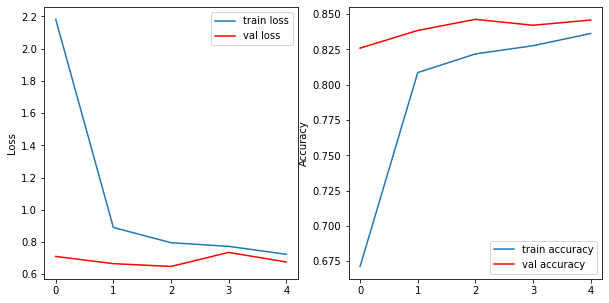

In [37]:
#Plotting the errors and accuracy
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot((history.history['loss']), label='train loss')
plt.plot((history.history['val_loss']), color='red', label='val loss')
plt.ylabel(r'Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot((history.history['accuracy']), label='train accuracy')
plt.plot((history.history['val_accuracy']), color='red', label='val accuracy')
plt.ylabel(r'Accuracy')
plt.legend()

plt.show()

### Fine Tuning

In [38]:
# Freezing and Unfreezing the required layers for fine tuning
for layers in classifier.layers[-15:]:
  layers.trainable = True

In [39]:
# Compiling the model
classifier.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Training the model
history = classifier.fit(train_data, validation_data=val_data, epochs=5,
                         batch_size=32, verbose=1)

Epoch 1/5
516/516 [==============================] - 517s 1s/step - loss: 0.5617 - accuracy: 0.8648 - val_loss: 0.5622 - val_accuracy: 0.8784
Epoch 2/5
516/516 [==============================] - 517s 1s/step - loss: 0.4484 - accuracy: 0.8859 - val_loss: 0.5586 - val_accuracy: 0.8878
Epoch 3/5
516/516 [==============================] - 511s 990ms/step - loss: 0.3745 - accuracy: 0.8980 - val_loss: 0.5429 - val_accuracy: 0.8934
Epoch 4/5
516/516 [==============================] - 517s 1s/step - loss: 0.3581 - accuracy: 0.9051 - val_loss: 0.5459 - val_accuracy: 0.8885
Epoch 5/5
516/516 [==============================] - 518s 1s/step - loss: 0.3111 - accuracy: 0.9135 - val_loss: 0.6027 - val_accuracy: 0.8944


In [42]:
# Freezing and Unfreezing the required layers for fine tuning
for layers in classifier.layers[-15:]:
  layers.trainable = False
for layers in classifier.layers[-30:-15]:
  layers.trainable = True
for layer in classifier.layers:
  if "Dense" in layer.__class__.__name__:
    layer.trainable=True

In [43]:
# Compiling the model
classifier.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Training the model
history = classifier.fit(train_data, validation_data=val_data, epochs=5,
                         batch_size=32, verbose=1)

Epoch 1/5
516/516 [==============================] - 516s 1s/step - loss: 0.2625 - accuracy: 0.9240 - val_loss: 0.5689 - val_accuracy: 0.8956
Epoch 2/5
516/516 [==============================] - 508s 985ms/step - loss: 0.2416 - accuracy: 0.9279 - val_loss: 0.5445 - val_accuracy: 0.8954
Epoch 3/5
516/516 [==============================] - 512s 993ms/step - loss: 0.2207 - accuracy: 0.9297 - val_loss: 0.5685 - val_accuracy: 0.9015
Epoch 4/5
516/516 [==============================] - 509s 986ms/step - loss: 0.2045 - accuracy: 0.9337 - val_loss: 0.5345 - val_accuracy: 0.8973
Epoch 5/5
516/516 [==============================] - 506s 981ms/step - loss: 0.1969 - accuracy: 0.9361 - val_loss: 0.5387 - val_accuracy: 0.8988


In [44]:
# Saving the model
classifier.save("InceptionResnet")
!zip "InceptionResnet.zip" -r ./InceptionResnet
IPython.display.clear_output() 

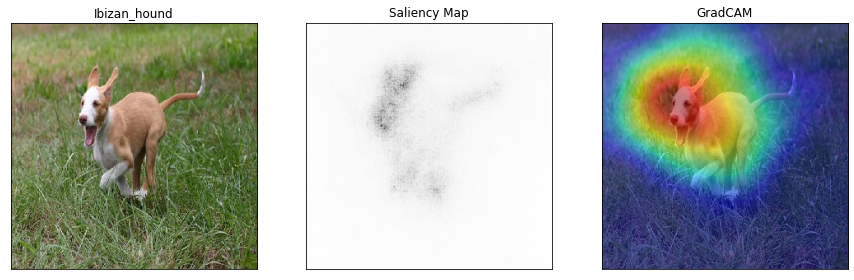

In [52]:
# Taking a look on what the model is seeing

def model_modifier(model):
    model.layers[-1].activation = tf.keras.activations.linear
    return model

def loss(output):
    return output[0,np.argmax(img_id)]

cnn = classifier
img, img_id = img_gen.next()

saliency = Saliency(cnn, model_modifier)
saliency_map = saliency(loss, img, 
                        smooth_samples=20,
                        smooth_noise=.2)
saliency_map = normalize(saliency_map)

gradcam = Gradcam(cnn, model_modifier)
cam = gradcam(loss, img, penultimate_layer=-1)
cam = normalize(cam)

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].imshow(np.squeeze(img))
ax[0].set_title(classes[np.argmax(img_id)])

ax[1].imshow(saliency_map[0], cmap='Greys')
ax[1].set_title("Saliency Map")

ax[2].imshow(np.squeeze(img))
ax[2].imshow(cam[0], alpha=.5, cmap='jet')
ax[2].set_title("GradCAM")

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

It seems like that the model is looking at facial features of the dogs to figure out the breed.

## **Part C:** Combining the two models

In [46]:
# Loading the models
classifier_test = load_model("InceptionResnet")
autoencoder_test = load_model("SuperResolution")

In [47]:
# Preprocess function for blurring the images
def preprocess_blur(img):
  factor = compression_factor
  img_n = cv2.resize(img, (img.shape[0]//factor, img.shape[1]//factor))
  img_n = cv2.resize(img_n, (img_n.shape[0]*factor, img_n.shape[1]*factor))
  img_n = img_n/255
  return img_n

# Preprocess function to upscale the blurred images using autoencoder
def preprocess_enhanced(img):
  img_n = preprocess_blur(img)
  img_enhanced = autoencoder_test.predict(np.expand_dims(img_n, axis=0))[0]
  return img_enhanced

### Reading and processing the data

In [48]:
data_dir = "/kaggle/input/stanford-dogs-dataset/images/Images"

datagen_blur = ImageDataGenerator(preprocessing_function=preprocess_blur, validation_split=0.2)
datagen_enhanced = ImageDataGenerator(preprocessing_function=preprocess_enhanced, validation_split=0.2)


val_data_blur = datagen_blur.flow_from_directory(data_dir, target_size=(300, 300), subset='validation', seed=20)
val_data_enhanced = datagen_enhanced.flow_from_directory(data_dir, target_size=(300, 300), subset='validation', seed=20)

Found 4072 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


### Calculating the accuracies

In [49]:
# Printing out the results
print("The validation accuracy for blur images is {:.2f}%".format(classifier_test.evaluate(val_data_blur, verbose=0)[1]*100))
print("The validation accuracy for autoencoder enhanced images is {:.2f}%".format(classifier_test.evaluate(val_data_enhanced, verbose=0)[1]*100))

The validation accuracy for blur images is 0.83
The validation accuracy for autoencoder enhanced images is 0.85
